# Amazon

This example uses the 'Amazon' dataset to predict the number of forest fires in Brazil. You can download a copy of the Jupyter Notebook of the study <a href="amazon.ipynb">here</a>.
<ul class="ul_content">
    <li><b>date: </b>Date of the record</li>
    <li><b>number: </b>Number of forest fires</li>
    <li><b>state: </b>State in Brazil</li>
</ul>
<p>We'll follow the data science cycle (Data Exploration - Data Preparation - Data Modeling - Model Evaluation - Model Deployment) to solve this problem, and we'll do it without ever loading our data into memory.</p>

## Initialization

This example uses the following version of VerticaPy:

In [1]:
import verticapy as vp
vp.__version__

'0.9.0'

Connect to Vertica. This example uses an existing connection called "VerticaDSN." For details on how to create a connection, use see the <a href="../../connection.php">connection tutorial</a>.

In [2]:
vp.connect("VerticaDSN")

Let's create a Virtual DataFrame of the dataset.

,📅dateDate,AbcstateVarchar(32),123numberInt
1,1998-01-01,ACRE,0
2,1998-01-01,ALAGOAS,0
3,1998-01-01,AMAPÁ,0
4,1998-01-01,AMAZONAS,0
5,1998-01-01,BAHIA,0

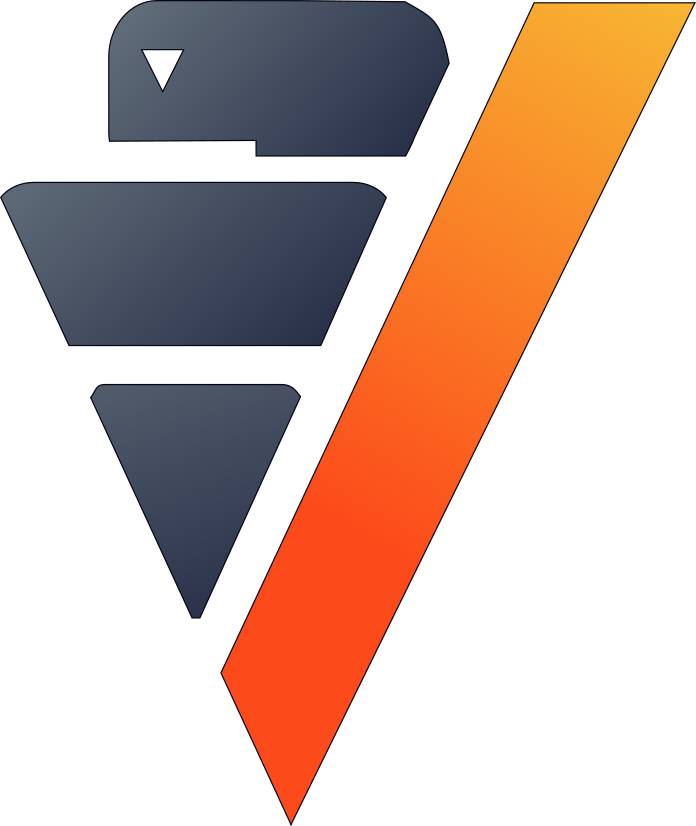

In [3]:
from verticapy.datasets import load_amazon
amazon = load_amazon()
amazon.head(5)

## Data Exploration and Preparation

We can explore our data by displaying descriptive statistics of all the columns.

,dtype,count,top,top_percent,unique
"""date""",date,6454,2017-01-01,0.434,239.0
"""state""",varchar(32),6454,ALAGOAS,3.719,27.0
"""number""",int,6454,0,9.56,1480.0

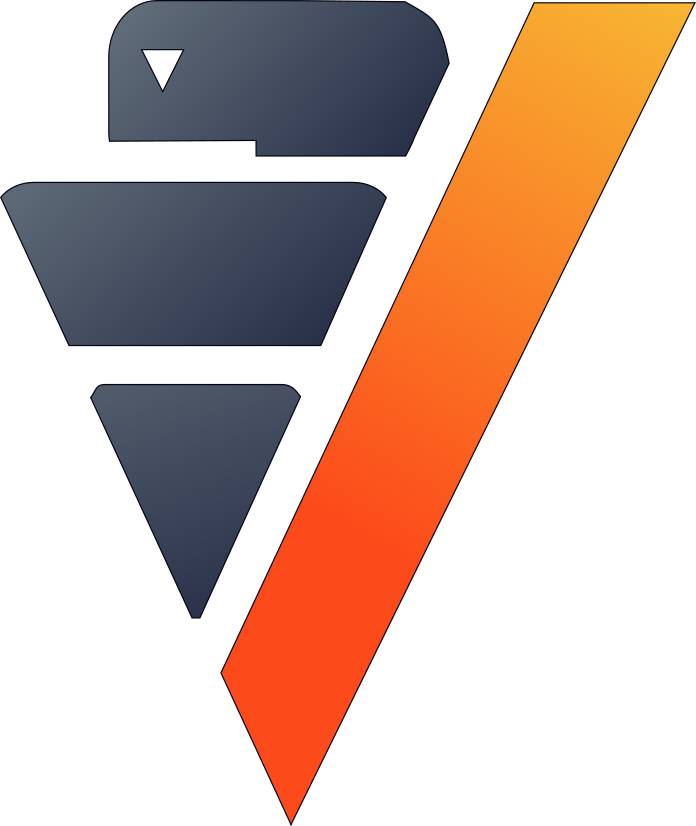

In [4]:
amazon.describe(method = "categorical", unique = True)

Using the describe() method, we can see that our data ranges from the beginning of 1998 to the end of 2017.

,value
name,"""date"""
dtype,date
count,6454
min,1998-01-01
max,2017-11-01

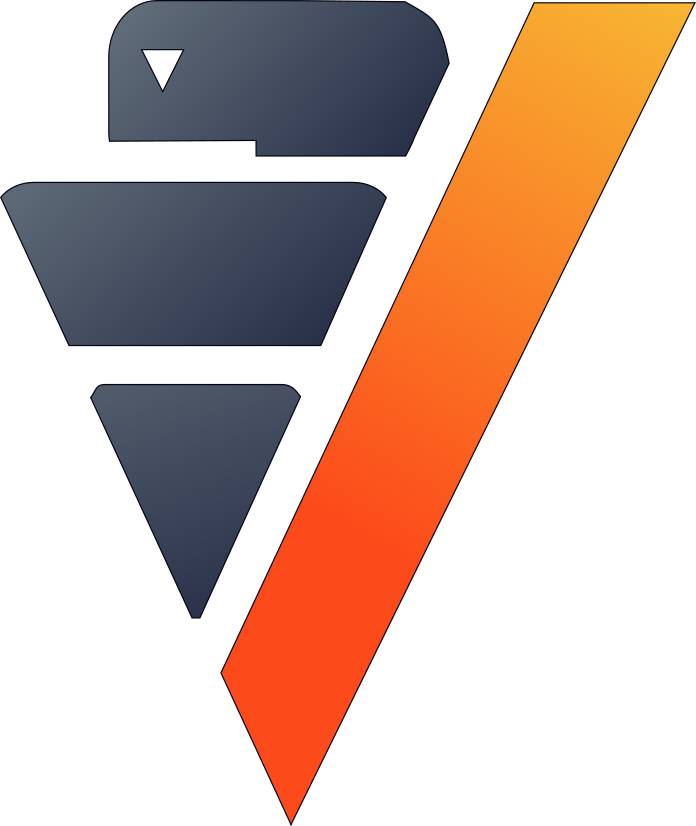

In [5]:
amazon["date"].describe()

Brazil has dry and rainy seasons. Knowing this, we would expect that the frequency of forest fires vary between seasons. Let's confirm our hypothesis using an autocorrelation plot with 48 lags (4 years).

,value,confidence
0,1.0,0.024396841824873755
1,0.673,0.036275983687006595
2,0.349,0.045111637590579914
3,0.165,0.052306855578449836
4,0.03,0.057263854711292146
5,-0.042,0.06180006129512837
6,-0.06,0.06516081663993491
7,-0.045,0.06829524194541631
8,0.026,0.07124360828375358
9,0.148,0.07407557653279681

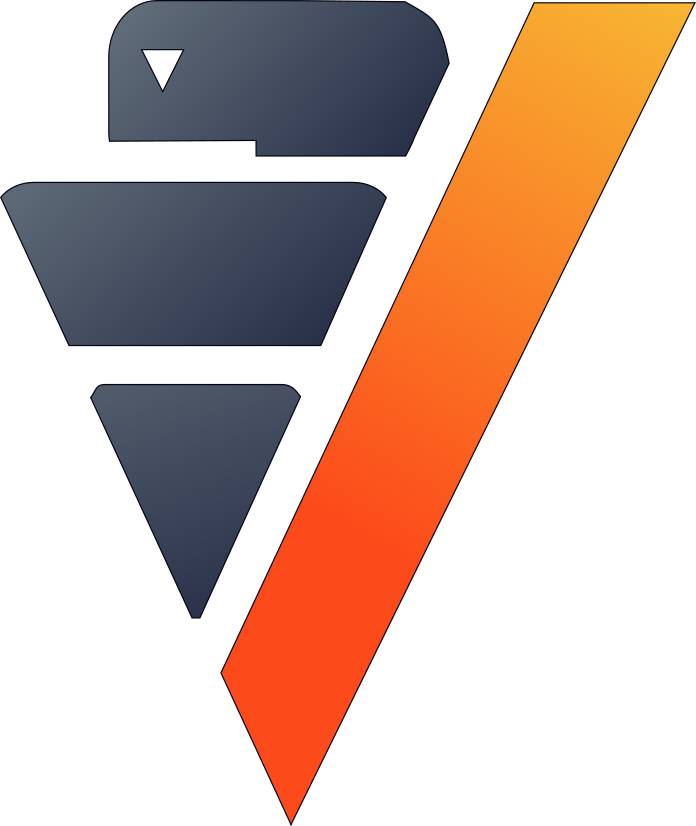

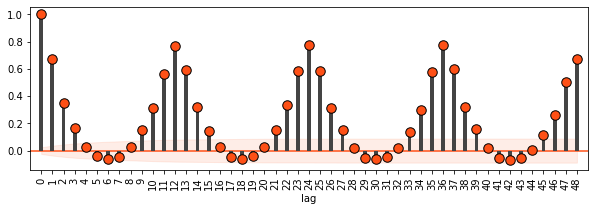

In [6]:
%matplotlib inline
amazon.acf(column = "number", 
           ts = "date",
           by = ["state"],
           p = 48)

The process is not stationary. Let's use a Dickey-Fuller test to confirm our hypothesis.

,value
ADF Test Statistic,-1.4627032775079862
p_value,0.143610439349909
# Lags used,48
# Observations Used,6454
Critical Value (1%),-3.43
Critical Value (2.5%),-3.12
Critical Value (5%),-2.86
Critical Value (10%),-2.57
Stationarity (alpha = 1%),❌

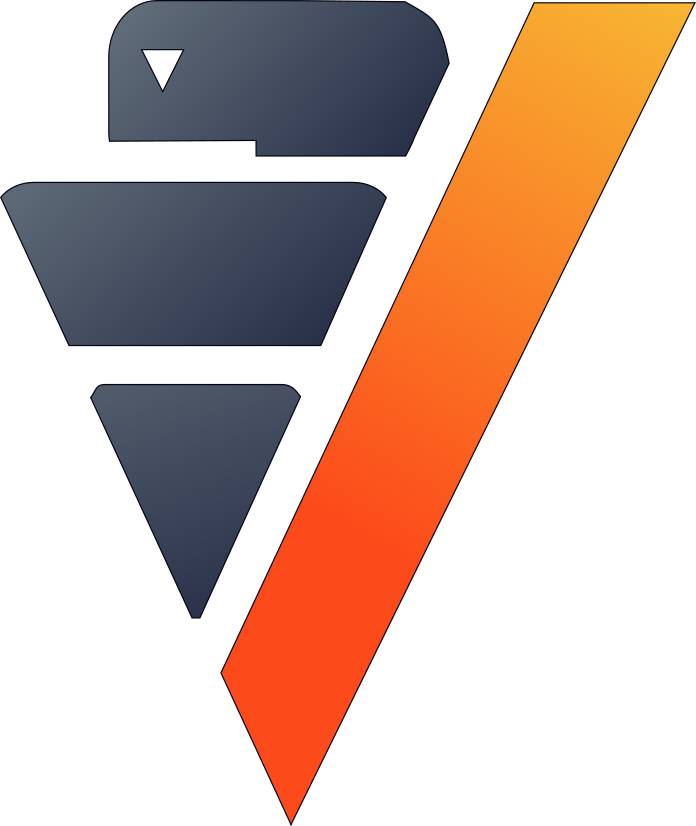

In [7]:
from verticapy.stats import adfuller
adfuller(amazon,
         ts = "date", 
         column = "number", 
         by = ["state"], 
         p = 48)

The effects of each season seem pretty clear. We can see this graphically using the cumulative sum of the number of forest fires partitioned by states. If our hypothesis is correct, we should see staircase functions.

<AxesSubplot:xlabel='"date"', ylabel='"cum_sum"'>

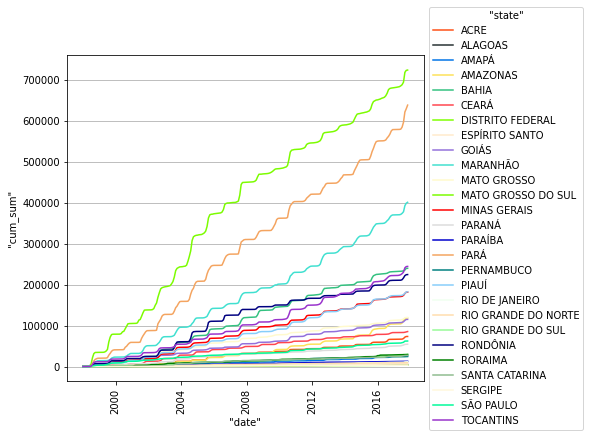

In [8]:
amazon.cumsum("number", 
              by = ["state"], 
              order_by = ["date"], 
              name = "cum_sum")
amazon["cum_sum"].plot(ts = "date", 
                       by = "state")

We can clearly see the seasonality per state which contributes to a global seasonality. Let's draw the cumulative sum to see this more clearly.

<AxesSubplot:xlabel='"date"', ylabel='"cum_sum"'>

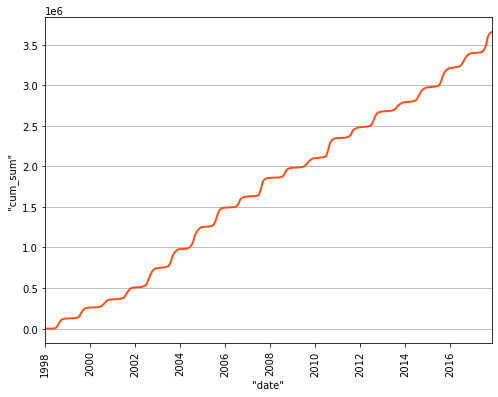

In [9]:
import verticapy.stats as st
amazon = amazon.groupby(["date"], 
                        [st.sum(amazon["number"])._as("number")])
amazon.cumsum("number", 
              order_by = ["date"], 
              name = "cum_sum")
amazon["cum_sum"].plot(ts = "date")

## Machine Learning

Let's create an spatial autoregressive (SAR) model to predict the number of forest fires in Brazil. We know that this seasonality happens each year (s=12) and let's consider 4 lags (P=4).

,value
explained_variance,0.735475202180538
max_error,53472.4790951474829625
median_absolute_error,2345.29902142932
mean_absolute_error,6098.51854215664
mean_squared_error,118668651.839548
root_mean_squared_error,10893.514209819896
r2,0.735475202180538
r2_adj,0.7297864968510872
aic,3561.3668585620294
bic,3577.3039013779385

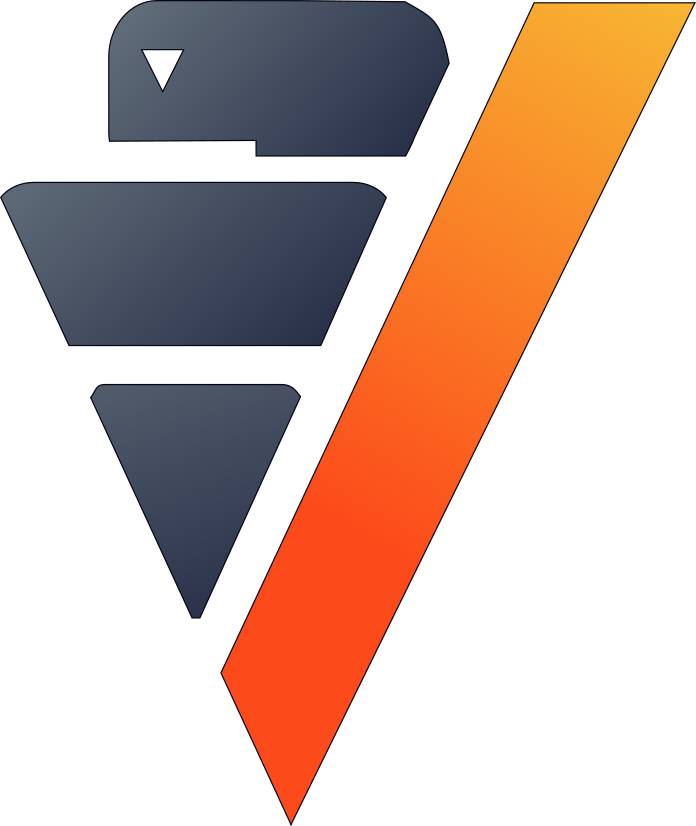

In [10]:
from verticapy.learn.tsa import SARIMAX

model = SARIMAX("amazon_ar", 
                s = 12, 
                P = 4)
model.fit(amazon,
          y = "number",
          ts = "date")
model.regression_report()

Our model is quite good. Let's look at our predictions.

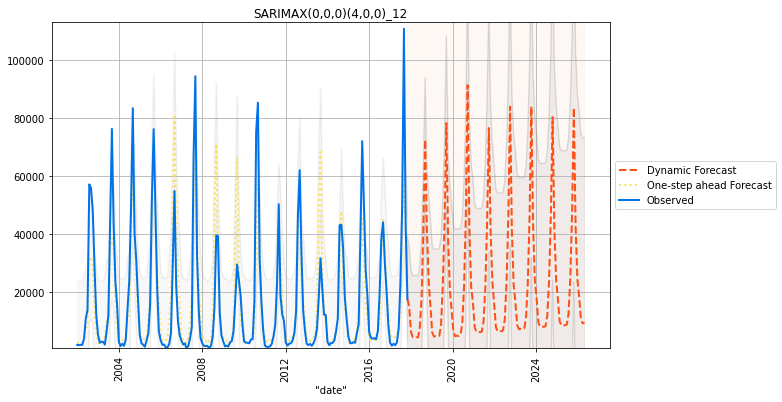

In [11]:
x = model.plot(amazon, 
               nlead=100, 
               dynamic=True)

The plot shows that our model has successfully captured the seasonality implied by our data. Let's add the prediction in the vDataFrame.

,📅dateDate,123cum_sumInteger,"123predictionNumeric(34,16)",123numberInteger
1,1998-01-01,0,[null],0
2,1998-02-01,0,[null],0
3,1998-03-01,0,[null],0
4,1998-04-01,0,[null],0
5,1998-05-01,0,[null],0
6,1998-06-01,3551,[null],3551
7,1998-07-01,11617,[null],8066
8,1998-08-01,47166,[null],35549
9,1998-09-01,89134,[null],41968
10,1998-10-01,112629,[null],23495

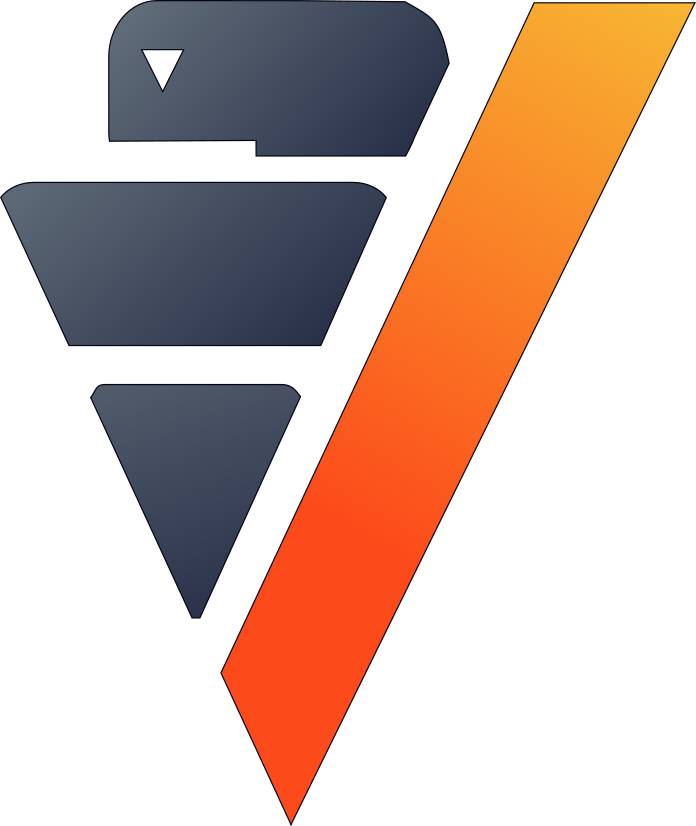

In [12]:
amazon = model.predict(amazon, name = "prediction")
display(amazon)

From here, we can use a time series plot to compare our prediction with the real values.

<AxesSubplot:xlabel='"date"'>

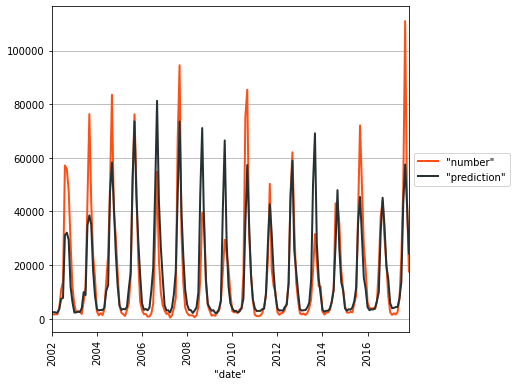

In [13]:
amazon.plot(ts = "date", 
            columns = ["number", "prediction"])

Our prediction seems to follow the trend! We can draw a boxplot to visualize the distribution of the real and predicted values.

<AxesSubplot:>

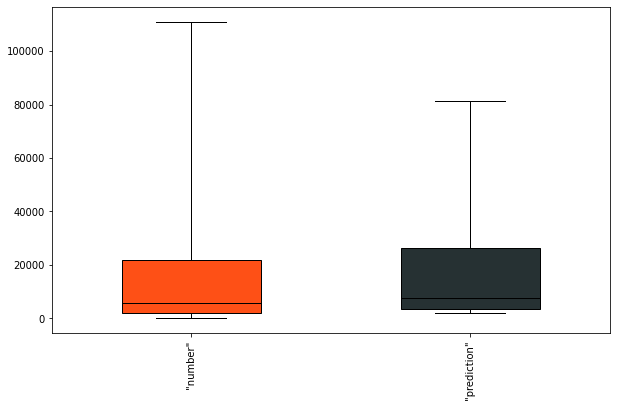

In [14]:
amazon.boxplot(columns = ["number", "prediction"])

Barring extreme outliers, our predictions seem to match up quite closely.

## Conclusion

We've solved our problem in a Pandas-like way, all without ever loading data into memory!